In [130]:
# Load in Libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt



In [131]:
# Create a reproducible file path
Eaton_fp = os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')
Palisades_fp = os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')
NC_fp = os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc')

In [132]:
# Read in data
Eaton = gpd.read_file(Eaton_fp)
Palisades = gpd.read_file(Palisades_fp)
Landsat_8 = xr.open_dataset(NC_fp)


## 2. Fire perimeter data exploration

In [133]:
# Check the crs
print(Eaton.crs)
print(Palisades.crs, "\n")

# Check dtypes
print(Eaton.dtypes)
print(Palisades.dtypes, "\n")

# Check column names
print(Eaton.columns)
print(Palisades.columns, "\n")

# Check column names
print(Eaton.columns)
print(Palisades.columns, "\n")

# Check shape of data
print(Eaton.shape)
print(Palisades.shape, "\n")

# Check if data are projected or geographic
print(f"The CRS of Eaton is projected: {Eaton.crs.is_projected}")
print(f"The CRS of Palisades is projected: {Palisades.crs.is_projected}", "\n")



EPSG:3857
EPSG:3857 

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object
OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object 

Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object')
Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object') 

Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object')
Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object') 

(20, 5)
(21, 5) 

The CRS of Eaton is projected: True
The CRS of Palisades is projected: True 



After exploring both the Eaton and the Palisades shape files I found that they have the same CRS. The CRS of both is projected. These shape files have the same data types, amount of columns, and column names. The only difference is in there rows. Palisades has 1 more row than Eaton. Since this data is so similar I will most likely join them later on for simplicity.

## 3. NetCDF data import and exploration

In [134]:
# Print Landsat_8
Landsat_8


<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

After exploring the Landsat_8 NetCDF file, I found that it's dimensions are (y: 1418, x: 2742). The coordinates of Landsat_8 are in the CRS EPSG:32611 and it's CRS is a projection. It's resolution is 30 and it's in units of meters. Both x and y have the data type of float64. Time has a data type of datetime64[ns]. The data’s variables are red(red visible light), green(visible green light), blue(visible blue light), nirO8(near-infrared light), swir22(shortwave infrared light), and spatial_ref(stores the dataset’s CRS/projection information). All the data types are float32 except for spatial_ref, which has a data type of int64.

## 4. Restoring geospatial information

In [135]:
# Use rio.crs to print the CRS of this dataset
print(Landsat_8.rio.crs, "\n")

# Print the CRS by using the spatial_ref.crs_wkt attribute
print(Landsat_8.spatial_ref.crs_wkt, "\n")

# Recover the geospatial information by using rio.write_crs()
Landsat_8.rio.write_crs(Landsat_8.spatial_ref.crs_wkt, inplace=True)

# Print the CRS of the updated dataset
print("Updated CRS:", Landsat_8.rio.crs, "\n")


None 

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]] 

Updated CRS: EPSG:32611 



## 5. True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


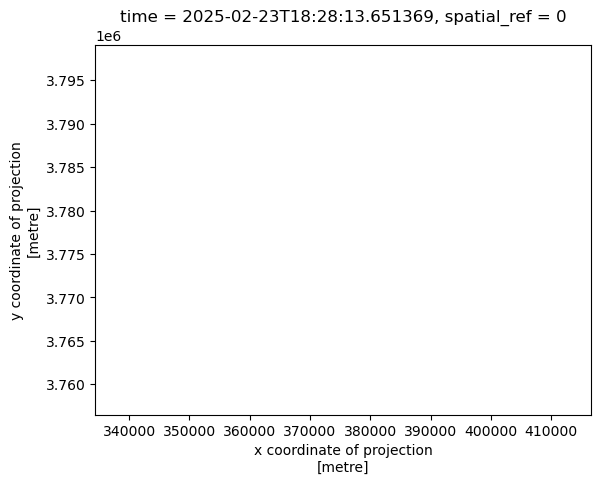

In [136]:
# select the red, green, and blue variables (in that order) of the xarray.Dataset holding the Landsat data
# Use .plot.imshow() to create an RGB image with the data

Landsat_8[["red", "green", "blue"]].to_array().plot.imshow()

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


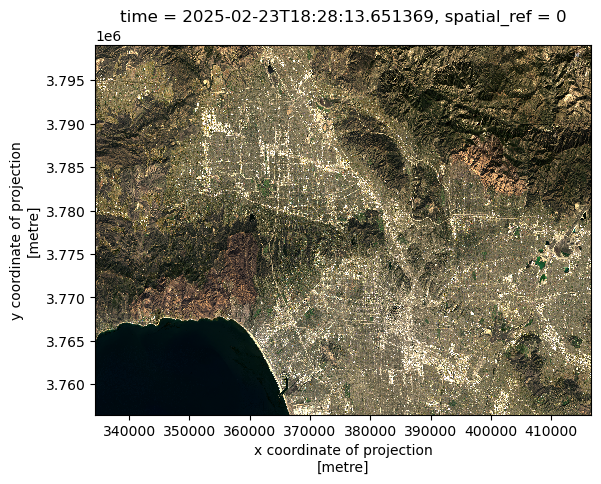

In [137]:
# Use .plot.imshow() to create an RGB image with the data
Landsat_8[["red", "green", "blue"]].to_array().plot.imshow(robust=True)

In [138]:
bands = ["red", "green", "blue"]

# Check for nans in each band
for band in bands:
    has_nan = np.isnan(Landsat_8[band].values).any()
    print(f"{band} contains NaN values? {has_nan}")

    

red contains NaN values? False
green contains NaN values? True
blue contains NaN values? True


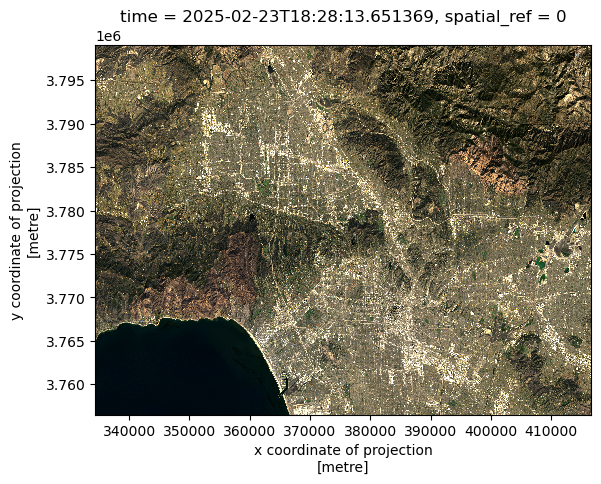

In [139]:
Landsat_8[["green", "blue"]] = Landsat_8[["green", "blue"]].fillna(0)
Landsat_8[["red", "green", "blue"]].to_array().plot.imshow(robust=True)

The ouputs for parts (a) and (e) are supposed to display a true color image. Unforntunitly, the output for part a displays no image and a warning. The output for part e displays an image with no warning. The outputs differ because part a's bands still contains nan values and extreme outlier pixel values from clouds. These two issues were fixed before part e's output by using .fillna() to replace nans with 0s in the blue and green bands. Also, robust was set to True to account for the extreme outlier pixel values.

## 6. False color image

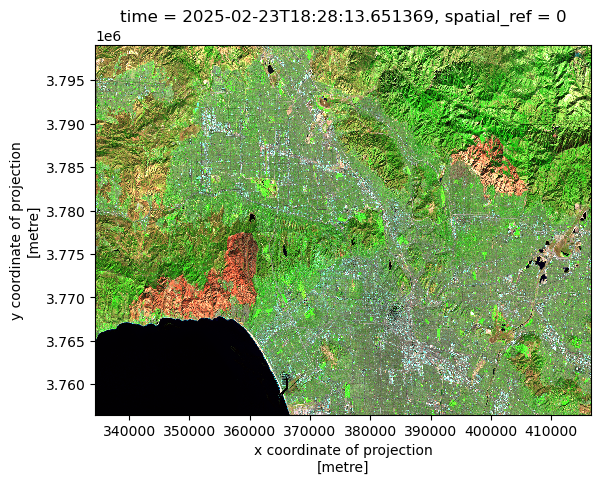

In [140]:
# Use .plot.imshow() to create a false color image with the data
Landsat_8[["swir22", "nir08", "red"]].to_array().plot.imshow(robust=True)

## 7. Map

In [141]:
Palisades = Palisades.to_crs(Landsat_8.rio.crs)
Eaton = Eaton.to_crs(Landsat_8.rio.crs)


#Landsat_8 = Landsat_8.rio.reproject(Palisades.crs)

print(Palisades.crs == Landsat_8.rio.crs)
print(Eaton.crs == Landsat_8.rio.crs)




bands = ["swir22", "nir08", "red"]

# Check for nans in each band
for band in bands:
    has_nan = np.isnan(Landsat_8[band].values).any()
    print(f"{band} contains NaN values? {has_nan}")

# Fill NaNs with 0 to avoid casting issues
Landsat_8[["swir22", "nir08"]] = Landsat_8[["swir22", "nir08"]].fillna(0)



True
True
swir22 contains NaN values? False
nir08 contains NaN values? False
red contains NaN values? False


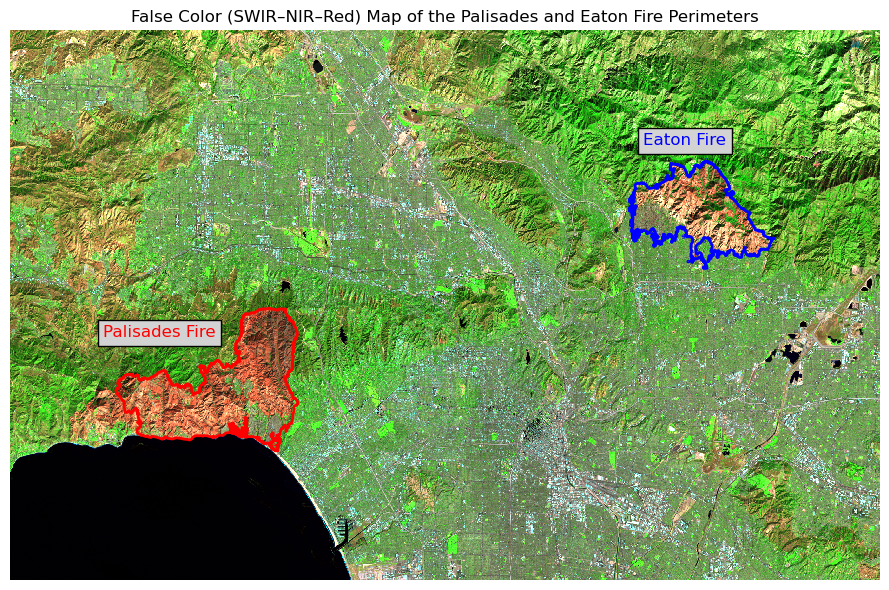

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Add fire perimeters
Palisades.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
Eaton.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2,legend=True)

# Add false color raster
Landsat_8[["swir22", "nir08", "red"]].to_array().plot.imshow(robust=True)

# Add title
ax.set_title('False Color (SWIR–NIR–Red) Map of the Palisades and Eaton Fire Perimeters')

# Add labels with gray background
plt.figtext(0.12, 0.43, "Palisades Fire", color='red', fontsize=12, bbox=dict(facecolor='lightgray'))
plt.figtext(0.72, 0.75, "Eaton Fire", color='blue', fontsize=12, bbox=dict(facecolor='lightgray'))

# Remove axes
ax.axis('off')
plt.tight_layout()
plt.show()

The map above shows a false color image of the LA County area, displaying the perimeter of fires that occured in the Palisades(in red) and Eaton(in blue). False color imagery is being used in the background image. The background image is made up of SWIR (short-wave infrared), NIR (near-infrared), and Red bands. These bands are used to enhances burn severity and vegetation patterns. The false colors in this background image show healthy vegetation as bright green, urban areas as cyan/gray, and burnt area areas as a reddish brown.